<a href="https://colab.research.google.com/github/sol-commits/machine_learning/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libarary

In [78]:
import time

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [81]:
from lightgbm import LGBMClassifier

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix

In [124]:
from imblearn.over_sampling import SMOTE

# Function

In [84]:
# 분류기의 성능을 return 하는 함수
def get_clf_eval(y_test, pred):
  acc = accuracy_score(y_test, pred)
  pre = precision_score(y_test, pred)
  re = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  auc = roc_auc_score(y_test, pred)

  return acc, pre, re, f1, auc

In [85]:
# 분류기의 성능을 출력하는 함수
def print_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

  print("== confusion matrix ==")
  print(confusion)
  print("======================")

  print(f'Accuracy: {acc:.4f}')
  print(f'Precision: {pre:.4f}')
  print(f'Recall: {re:.4f}')
  print(f'F1 Score: {f1:.4f}')
  print(f'ROC AUC Score: {auc:.4f}')

In [86]:
# 모델과 데이터를 넘기면 성능을 계산하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

  return get_clf_eval(y_test, pred)

In [87]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
  col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
  result_list = []

  for model in models:
    result_list.append(get_result(model, X_train, y_train, X_test, y_test))

  return pd.DataFrame(result_list, columns=col_names, index=model_names)

In [115]:
# outlier의 인덱스를 반환하는 함수
def get_outlier(df=None, column=None, weight=1.5):
  fraud = df[df['Class'] == 1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)

  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lower_val = quantile_25 - iqr_weight
  higher_val = quantile_75 + iqr_weight

  outlier_index = fraud[(fraud < lower_val) | (fraud > higher_val)].index

  return outlier_index

# Data

[캐글의 Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

- 금융 데이터이고 기업의 기밀 보호를 위해 대다수 feature의 이름은 삭제되어 있음
- `Class` feature : Fraud 여부

In [88]:
data_path = '/content/drive/MyDrive/my_ws/edu/machine_learning/data/creditcard.csv'
raw_data = pd.read_csv(data_path)
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [89]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Class NaN 데이터 제거

In [90]:
# Class 데이터에 하나의 NaN 있음
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132784 entries, 0 to 132783
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    132784 non-null  int64  
 1   V1      132784 non-null  float64
 2   V2      132784 non-null  float64
 3   V3      132784 non-null  float64
 4   V4      132784 non-null  float64
 5   V5      132784 non-null  float64
 6   V6      132784 non-null  float64
 7   V7      132784 non-null  float64
 8   V8      132784 non-null  float64
 9   V9      132784 non-null  float64
 10  V10     132784 non-null  float64
 11  V11     132784 non-null  float64
 12  V12     132784 non-null  float64
 13  V13     132784 non-null  float64
 14  V14     132784 non-null  float64
 15  V15     132784 non-null  float64
 16  V16     132784 non-null  float64
 17  V17     132784 non-null  float64
 18  V18     132784 non-null  float64
 19  V19     132784 non-null  float64
 20  V20     132784 non-null  float64
 21  V21     13

In [91]:
raw_data.dropna(subset={'Class'}, inplace=True)
len(raw_data)

132783

## 데이터 label의 불균형

In [92]:
raw_data['Class'].value_counts()

,count
Class,
0.0,132521
1.0,262


### Fraud 비율 0.2%

In [93]:
fraud_rate = round((raw_data['Class'].value_counts()[1]/len(raw_data))*100, 2)
print(f'Fraud {fraud_rate}% of the dataset')

Fraud 0.2% of the dataset


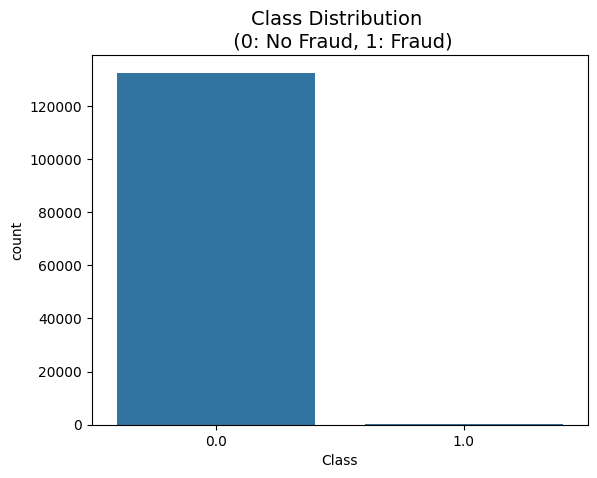

In [94]:
sns.countplot(x='Class', data=raw_data)
plt.title('Class Distribution \n (0: No Fraud, 1: Fraud)', fontsize=14)
plt.show()

## label 분리

In [95]:
X = raw_data.iloc[:, 1:-1] # Time Feature 제외
y = raw_data.iloc[:, -1]

X.shape, y.shape

((132783, 29), (132783,))

# 앙상블 기법 - Boosting 기법 이론

- 앙상블은 전통적으로 `voting`, `bagging`, `boosting`, `스태깅` 등으로 나눔
- `voting` 과 `baggin` 은 여러개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
  - 차이점은 `voting`은 각각 다른 분류기, `bagging`은 같은 분류기를 사용
- 대표적인 `bagging` 방식이 `Random Forest`


## Boosting

- 여러 개의 (약한) 분류기가 순차적으로 학습을 하면서, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해 다음 분류기가 가중치를 인가해서 학습을 이어 진행하는 방식
- 예측 성능이 뛰어나서 앙상블 학습을 주도하고 있음
- 기법에는 그래디언트부스트, XGBoost, LightGBM 등이 있음
  - GBM: AdaBoost 기법과 비슷하지만, 가중치를 업데이트할 때 경사하강법(Gradient Descent)을 사용
  - XGBoost: GBM에서 PC의 파워를 효율적으로 사용하기 위한 다양한 기법에 채택되어 빠른 속도와 효율을 가짐
  - LightGBM: XGBoost보다 빠른 속도를 가짐
<br>

- `bagging`은 `parallel`
- `boosting`은 `sequential`

# 간단하게 4개 분류 모델 적용

## train, test 데이터 분리

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

### train 데이터에서 Fraud 비율 0.2%

In [97]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([106016,    210]))

In [98]:
np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100

0.19769171389302054

## Logistic Regression

- label 데이터의 불균형으로 Accuracy가 높게 나옴

In [99]:
lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

== confusion matrix ==
[[26500     5]
 [   21    31]]
Accuracy: 0.9990
Precision: 0.8611
Recall: 0.5962
F1 Score: 0.7045
ROC AUC Score: 0.7980


## Decision Tree

In [100]:
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

== confusion matrix ==
[[26502     3]
 [    7    45]]
Accuracy: 0.9996
Precision: 0.9375
Recall: 0.8654
F1 Score: 0.9000
ROC AUC Score: 0.9326


## Random Forest

In [101]:
rf_clf = RandomForestClassifier(random_state=13, n_estimators=100, n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

== confusion matrix ==
[[26503     2]
 [    7    45]]
Accuracy: 0.9997
Precision: 0.9574
Recall: 0.8654
F1 Score: 0.9091
ROC AUC Score: 0.9327


## LightGBM

In [102]:
lgbm_clf = LGBMClassifier(random_state=13, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

[LightGBM] [Info] Number of positive: 210, number of negative: 106016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 106226, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
== confusion matrix ==
[[26504     1]
 [    9    43]]
Accuracy: 0.9996
Precision: 0.9773
Recall: 0.8269
F1 Score: 0.8958
ROC AUC Score: 0.9134


## 4개의 분류 모델을 표로 정리

In [103]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print(f'걸린 시간: {round(time.time() - start_time, 2)}초')
results

[LightGBM] [Info] Number of positive: 210, number of negative: 106016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 106226, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
걸린 시간: 93.63초


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.999021,0.861111,0.596154,0.704545,0.797983
Decision Tree,0.999623,0.937500,0.865385,0.900000,0.932636
Random Forest,0.999661,0.957447,0.865385,0.909091,0.932655
LightGBM,0.999623,0.977273,0.826923,0.895833,0.913443


# Amount 데이터 정리 후 4개 분류 모델 적용

## 특정 대역에 몰려 있는 신용카드 사용금액(Amount)의 분포

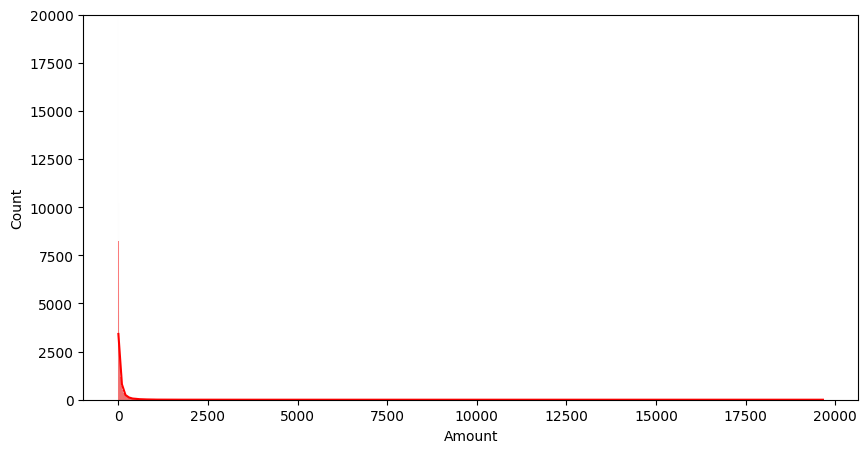

In [104]:
plt.figure(figsize=(10, 5))
sns.histplot(raw_data["Amount"], color='r', kde=True)
plt.ylim(0, 20000)
plt.show()

## Amount 컬럼에 StandardScaler 적용

In [105]:
scaler = StandardScaler()
amount_n = scaler.fit_transform(raw_data['Amount'].values.reshape(-1, 1))

raw_data_copy = raw_data.iloc[:, 1:-2]
raw_data_copy['Amount_scaled'] = amount_n
raw_data_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.229496
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.357756
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.144927
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.125099
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.088770


### 4개의 분류 모델 평가

In [106]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.3, random_state=13, stratify=y)

In [107]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print(f'걸린 시간: {round(time.time() - start_time, 2)}초')
results

[LightGBM] [Info] Number of positive: 183, number of negative: 92765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 92948, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
걸린 시간: 76.53초


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.998921,0.833333,0.569620,0.676692,0.784697
Decision Tree,0.999423,0.900000,0.797468,0.845638,0.898646
Random Forest,0.999623,0.944444,0.860759,0.900662,0.930329
LightGBM,0.999674,0.985294,0.848101,0.911565,0.924038


## Amount 컬럼에 Log Scale

In [108]:
amount_log = np.log1p(raw_data['Amount'])

raw_data_copy['Amount_scaled'] = amount_log
raw_data_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539


### Log Scaled Amount 분포

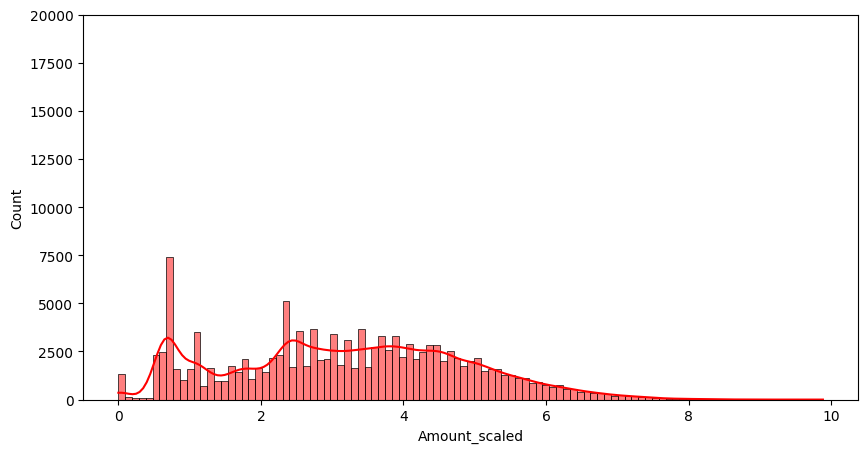

In [109]:
plt.figure(figsize=(10, 5))
sns.histplot(raw_data_copy["Amount_scaled"], color='r', kde=True)
plt.ylim(0, 20000)
plt.show()

### 4개의 분류 모델 평가

In [110]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.3, random_state=13, stratify=y)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print(f'걸린 시간: {round(time.time() - start_time, 2)}초')
results

[LightGBM] [Info] Number of positive: 183, number of negative: 92765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 92948, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
걸린 시간: 79.33초


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.998895,0.830189,0.556962,0.666667,0.778368
Decision Tree,0.999423,0.900000,0.797468,0.845638,0.898646
Random Forest,0.999623,0.944444,0.860759,0.900662,0.930329
LightGBM,0.999623,0.984848,0.822785,0.896552,0.911380


# V14 데이터의 Outlier 정리 후 4개 분류 모델 적용

<Axes: >

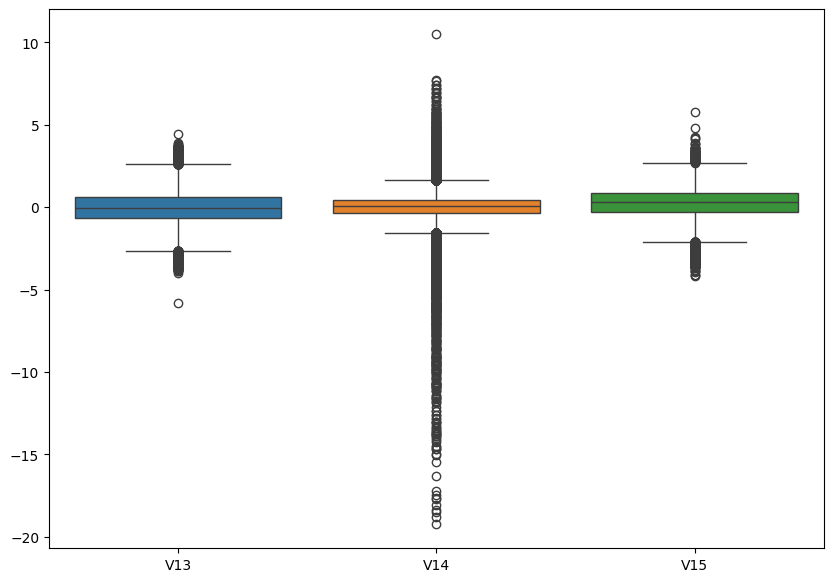

In [114]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=raw_data[['V13', 'V14', 'V15']])

In [118]:
get_outlier(df=raw_data, column='V14')

Index([8296, 8615, 9035, 9252, 9487, 9509, 10568, 41943], dtype='int64')

In [119]:
raw_data_copy.shape

(132783, 29)

In [120]:
# V14의 아웃라이어 제거
outlier_index = get_outlier(df=raw_data, column='V14')
raw_data_copy.drop(outlier_index, axis=0, inplace=True)
raw_data_copy.shape

(132775, 29)

## 4개의 분류 모델 평가

In [122]:
X = raw_data_copy
y = raw_data.drop(outlier_index, axis=0).iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [123]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

print(f'걸린 시간: {round(time.time() - start_time, 2)}초')
results

[LightGBM] [Info] Number of positive: 178, number of negative: 92764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 92942, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
걸린 시간: 78.36초


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.998971,0.830189,0.578947,0.682171,0.789360
Decision Tree,0.999498,0.888889,0.842105,0.864865,0.920952
Random Forest,0.999598,0.954545,0.828947,0.887324,0.914436
LightGBM,0.999598,0.968750,0.815789,0.885714,0.907870


# SMOTE Oversampling 후 4개 분류 모델 적용

적은 데이터 세트에 있는 개별 데이터를 `KNN` 방법으로 찾아서 데이터의 분포 사이에 새로운 데이터를 만드는 방식

In [125]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [127]:
X_train.shape, y_train.shape, X_train_over.shape, y_train_over.shape

((92942, 29), (92942,), (185528, 29), (185528,))

In [128]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_over, return_counts=True))

(array([0., 1.]), array([92764,   178]))
(array([0., 1.]), array([92764, 92764]))


In [129]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

start_time = time.time()
results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

print(f'걸린 시간: {round(time.time() - start_time, 2)}초')
results

[LightGBM] [Info] Number of positive: 92764, number of negative: 92764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 185528, number of used features: 29
걸린 시간: 159.39초


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.973540,0.060252,0.881579,0.112795,0.927647
Decision Tree,0.959983,0.040000,0.868421,0.076477,0.914290
Random Forest,0.999498,0.900000,0.828947,0.863014,0.914386
LightGBM,0.999297,0.785714,0.868421,0.825000,0.933984
